In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pymysql pyhrv py-ecg-detectors hrv-analysis pyhrv mne  EMD-signal biosppy sampen pyedflib heartpy

In [ ]:
%cd /content/drive/MyDrive/cs/mission_1/wysensor/
import hrv, arrhythmia, sleepstage

/content/drive/MyDrive/cs/mission_1/wysensor


In [ ]:
import mne
import os
import pymysql
import pandas as pd

from datetime import datetime, timedelta

import pymysql # DB 연결
import math
import time

import numpy as np # array사용

import matplotlib as mpl
import matplotlib.pyplot as plt # 그래프
import matplotlib.patches as patches # 그래프

from pyhrv import time_domain, frequency_domain, nonlinear, tools # hrv그래프 그리기
import traceback
import hrvanalysis # hrv계산

from ecgdetectors import Detectors # ECG 피크 감지 pip3 install py-ecg-detectors
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error # smse를 계산하기 위해
from IPython.core.display import HTML # Dataframe을 표로 출력하기 위해

from scipy import signal
from scipy.ndimage import label
from scipy.stats import zscore
from scipy.interpolate import interp1d
from scipy.integrate import trapz

data = pd.read_csv('./a.csv')
data.astype('float')

In [ ]:
def searchPatient(directory, output=[]):
    filelist = os.listdir(directory)
    for file in filelist:
        file_dir = os.path.join(directory, file)
        if os.path.isdir(file_dir):
            output = searchPatient(file_dir, output)
        elif file.endswith(".edf"):
            output.append(directory)
    return output
    
Patientlist = searchPatient(os.path.join(os.getcwd(), "/content/drive/MyDrive/cs/mission_1/input"))
Patientlist

['/content/drive/MyDrive/cs/mission_1/input/koj',
 '/content/drive/MyDrive/cs/mission_1/input/ktj',
 '/content/drive/MyDrive/cs/mission_1/input/kgk',
 '/content/drive/MyDrive/cs/mission_1/input/kjh',
 '/content/drive/MyDrive/cs/mission_1/input/kdh']

In [ ]:
len(Patientlist)

5

Patientlist
for i in Patientlist:
    print(i+'/Traces.edf')

In [ ]:
# FLAG_MATPLOT = False

# def get_hrv(nni, fig_file_name=None):
#     try:
#         nni = np.asarray(nni)
#         print(nni)
#         output = {}

#         time_domain_features = hrvanalysis.get_time_domain_features (nni) # time domain HRV를 계산
#         output.update(time_domain_features)

#         frequency_domain_features = hrvanalysis.get_frequency_domain_features(nni) # frequency domain HRV를 계산
#         output.update(frequency_domain_features)

#         sampen = hrvanalysis.get_sampen(nni) # sample entropy 를 계산
#         output.update(sampen)

#         csi_cvi_features = hrvanalysis.get_csi_cvi_features(nni) # sample entropy 를 계산
#         output.update(csi_cvi_features)

#         poincare_plot_features = hrvanalysis.get_poincare_plot_features(nni) # poincare plot 계산
#         output.update(poincare_plot_features)

#         geometrical_features = hrvanalysis.get_geometrical_features(nni) # geometrical 계산
#         output.update(geometrical_features)

#         output['SRD'] = SRD(nni)
#         output['PSI'] = PSI(nni=nni)
#         output['MSI'] = output['lfnu'] / output['hfnu'] # https://patentimages.storage.googleapis.com/37/e3/06/17222846f6f94b/KR100493714B1.pdf 수학식 18
        
#         output['SNS'], output['PNS'] = ANS(output['mean_hr'], output['PSI'], output['sd2'], output['mean_nni'], output['rmssd'], output['sd1'])

#         if 'percentile_hr' in output:
#             del output['percentile_hr']
#         for key in output:
#             if output[key] is None:
#                 output[key] = -1
#             elif math.isinf(output[key]):
#                 output[key] = -1
                
#         if FLAG_MATPLOT:
#             if fig_file_name is not None:
#                 fig_file_name = fig_file_name.replace(":", "")
#                 fig_file_name = fig_file_name.replace("-", "")
#                 fig_file_name = fig_file_name.replace(" ", "")

#             result = tools.tachogram(nni=nni, show=False)
        
        
#             if fig_file_name is not None:
#                 result['tachogram_plot'].savefig(f"{fig_output_path}{fig_file_name}_tachogram.jpg")
#                 output['tachogram_url'] = f"{fig_output_path}{fig_file_name}_tachogram.jpg"
#             plt.close()

#             result = time_domain.triangular_index(nni=nni, show=False)
        
        
#             if fig_file_name is not None:
#                 result['tri_histogram'].savefig(f"{fig_output_path}{fig_file_name}_triangular_index.jpg")
#                 output['triangular_index_url'] = f"{fig_output_path}{fig_file_name}_triangular_index.jpg"
#             plt.close()

#             result = frequency_domain.welch_psd(nni=nni, show=False)
#             if fig_file_name is not None:
#                 result['fft_plot'].savefig(f"{fig_output_path}{fig_file_name}_welch_psd.jpg")
#                 output['welch_psd_url'] = f"{fig_output_path}{fig_file_name}_triangular_index.jpg"
#             plt.close()

#             result = nonlinear.poincare(nni, show=False)
#             if fig_file_name is not None:
#                 result['poincare_plot'].savefig(f"{fig_output_path}{fig_file_name}_poincare.jpg")
#                 output['poincare_url'] = f"{fig_output_path}{fig_file_name}_triangular_index.jpg"
#             plt.close()

#             result = dNNI_NNI(nni, show=False)
#             if fig_file_name is not None:
#                 result.savefig(f"{fig_output_path}{fig_file_name}_dnni_nni.jpg")
#                 output['dnni_nni_url'] = f"{fig_output_path}{fig_file_name}_dnni_nni.jpg"
#             plt.close()

#         return output
#     except Exception as e:
#         print(traceback.format_exc())
#         return {'mean_nni':0,'sdnn':0,'sdsd':0,'nni_50':0,'pnni_50':0,'nni_20':0,'pnni_20':0,'rmssd':0,'median_nni':0,
#         'range_nni':0,'cvsd':0,'cvnni':0,'mean_hr':0,'max_hr':0,'min_hr':0,'std_hr':0,'median_hr':0,
#         'mad':0,'lf':0,'hf':0,'lf_hf_ratio':0,'lfnu':0,'hfnu':0,'total_power':0,'vlf':0,'sampen':0,'csi':0,'cvi':0,'Modified_csi':0,
#         'sd1':0,'sd2':0,'ratio_sd2_sd1':0,'triangular_index':0,'tinn':0,'SRD':0,'PSI':0,'MSI':0,'SNS':0,'PNS':0}

In [ ]:
FLAG_MATPLOT=False
plt.style.use(['seaborn-ticks']) # 그래프 테마 선택. 배경이 투명하지 않음.

fig_output_path = "/home/wapeul/add/db_image/"

'''
ANS(mean_hr, PSI, sd2, mean_nni, rmssd, sd1)

mean_hr, PSI, sd2, mean_nni, rmssd, sd1으로 SNS, PNS을 계산
https://www.kubios.com/hrv-ans-function/

1. DB연결
2. DB내에서 모든 ECG데이터의 mean_hr, PSI, sd2, mean_nni, rmssd, sd1의 평균, 분산값을 가져온다.
3. SNS, PNS 계산

parameter
    mean_hr, PSI, sd2, mean_nni, rmssd, sd1
return
    SNS, PNS
'''
def ANS(mean_hr, PSI, sd2, mean_nni, rmssd, sd1):
    try:
        # 1. DB연결
        conn = pymysql.connect(host='localhost', user='wysensor', password='wysensor1234', db='simdori', charset='utf8')
        curs = conn.cursor(pymysql.cursors.DictCursor)
        # 2. DB내에서 모든 ECG데이터의 mean_hr, PSI, sd2, mean_nni, rmssd, sd1의 평균, 분산값을 가져온다.
        curs.execute("SELECT * FROM ECG_HRV_Parameter")
        rows = curs.fetchall()
        for row in rows:
            param = row
            break
        conn.close()
    except Exception:
        # DB 연결에 실패했을때
        # DB 에서 값을 가져오지 못함으로 아래 값으로 계산한다.
        # 아래 값은 2021-02-15 13:40:00 기준 계산값
        try:
            conn.close()
        except UnboundLocalError: # conn가 연결되지 못햇을때.
            pass
        param = {'mean_nni_average':855.11,'rmssd_average':20.04,'sd1_average':14.37,'mean_hr_average':71.57,
        'sd2_average':22.32,'psi_average':1.70,'mean_nni_standard_deviation':198.62,'rmssd_standard_deviation':158.69,
        'sd1_standard_deviation':117.19,'mean_hr_standard_deviation':17.00,'sd2_standard_deviation':146.53,'psi_standard_deviation':2.58}

    # 각 값들의 Zscore를 계산
    mean_hr_z = (mean_hr - param['mean_hr_average']) / param['mean_hr_standard_deviation']
    psi_z  = (PSI - param['psi_average']) / param['psi_standard_deviation']
    sd2_z = (sd2 - param['sd2_average']) / param['sd2_standard_deviation']

    mean_nni_z = (mean_nni - param['mean_nni_average']) / param['mean_nni_standard_deviation']
    rmssd_z = (rmssd - param['rmssd_average']) / param['rmssd_standard_deviation']
    sd1_z = (sd1 - param['sd1_average']) / param['sd1_standard_deviation']

    # SNS는 mean_hr, PSI, sd2 값들의 Zscore의 절대값 평균.
    SNS = np.mean(np.abs((mean_hr_z, psi_z, sd2_z)))
    # PNS는 mean_nni, rmssd, sd1 값들의 Zscore의 절대값 평균.
    PNS = np.mean(np.abs((mean_nni_z + rmssd_z + sd1_z)))

    return SNS, PNS

'''
SRD(nni, vaildation_split=0.2)

mean_hr, PSI, sd2, mean_nni, rmssd, sd1으로 SNS, PNS을 계산
https://patentimages.storage.googleapis.com/37/e3/06/17222846f6f94b/KR100493714B1.pdf
수학식 7 SRD 공식

parameter
    nni, vaildation_split
    vaildation_split: 기본값은 0.2로 1:4 비율로 train세트와 test세트를 나눈다.
return
    SRD
'''
def SRD(nni, vaildation_split=0.2):
    length = len(nni) - 1 # 전체 길이 - 첫번째 nni는 제외
    train_length = int(length * vaildation_split) # train데이터 개수
    test_length = length - train_length # test데이터 개수

    train = np.sum((nni[1:train_length+1] * np.abs(nni[1:train_length+1] - nni[0:train_length])) ** 0.5) / train_length
    test = np.sum((nni[train_length+1:length] * np.abs(nni[train_length+1:length] - nni[train_length:length-1])) ** 0.5) / test_length

    return test / train

# https://github.com/maria-korosteleva/Anti-Stress-Tracker
# pysical stress index

'''
PSI(hr=None, nni=None)

PSI을 계산
https://github.com/maria-korosteleva/Anti-Stress-Tracker

parameter
    hr or nni
return
    SRD
'''
def PSI(hr=None, nni=None):
    if hr is None and nni is not None: # chc nni를 주면 hr로 변경
        hr = 60000 / nni
    elif hr is None and nni is not None: # chc nni, hr둘다 안주면 return
        return 0

    # see http://www.cardiometry.net/issues/no10-may-2017/heart-rate-variability-analysis
    # originally from R.M. Bayevcky, O.I. Kirillov, S.Z. Kletskin.
    # Mathematical analysis of Cardiac Rhythm under stress. In Hauka, 1984. [In Russian]
    # score = AMo / (2 * VR * Mo)
    # R-R interval - time delay between consecutive heart beats (assumed to be inverse value of the bpm)
    # Mo - mode - most frequent R-R interval value
    # AMo - mode amplitude - % of the intervals corresponding to Mode
    # VR - variational range - difference  between min and max R-R intervals

    r_r = [round(60. / float(r), 3) for r in hr]

    if len(r_r) == 0:
        return 0  # give up to calculate the score to prevent division by zero

    # naive calculations, might be improved
    min_r_r = 200
    max_r_r = 0
    mode = 0
    mode_freq = 0
    for record in r_r:
        if record < min_r_r:
            min_r_r = record
        if record > max_r_r:
            max_r_r = record
        freq = r_r.count(record)
        if freq > mode_freq:
            mode_freq = freq
            mode = record
    # DEBUG
    # print r_r
    # print min, max, mode, mode_freq

    VR = max_r_r - min_r_r
    Amode = mode_freq / float(len(r_r)) * 100

    if abs(VR) < 0.0001:
        return 0  # give up to calculate the score to prevent division by zero

    return min(1000, round(Amode / (2 * VR * mode)))

# Frequency_domain_components 그래프그리기
def Frequency_domain_components(TP, VLF, LF, HF): # 정상범위 표시 추가 필요.
    TP, VLF, LF, HF = np.log(TP), np.log(VLF), np.log(LF), np.log(HF)

    plt.figure(figsize=(6,4))
    plt.title("Frequency Domain Components")
    plt.bar(['TP', 'VLF', 'LF', 'HF'], [0, VLF, LF, HF], width=0.5, edgecolor='k', color='skyblue')
    plt.bar(['TP', 'VLF', 'LF', 'HF'], [TP, 0, 0, 0], width=0.5, edgecolor='k', color='y')

    plt.text(0, TP+0.1, f"{TP:.1f}", ha='center')
    plt.text(1, VLF+0.1, f"{VLF:.1f}", ha='center')
    plt.text(2, LF+0.1, f"{LF:.1f}", ha='center')
    plt.text(3, HF+0.1, f"{HF:.1f}", ha='center')

    plt.ylabel("Ln")
    plt.ylim(0, 12)
    plt.xlim(-1,4)

    ax = plt.gca()
    ax.axes.yaxis.set_visible(False)

    plt.show()

# Autonomic_balance_diagram 그래프그리기
def Autonomic_balance_diagram(LF, HF):
    plt.figure(figsize=(5,5))
    plt.title("Autonomic Balance Diagram")
    plt.scatter(np.log(LF), np.log(HF), marker='o', c='y', s=100, edgecolor='k')

    plt.xlabel("Low Frequency [Ln]")
    plt.xticks([0, 3, 6, 9, 12])
    plt.xlim(0,12)

    plt.ylabel("High Frequency [Ln]")
    plt.yticks([0, 3, 6, 9, 12])
    plt.ylim(0,12)

    plt.grid()
    plt.show()

# SampEn_SRD 그래프그리기
def SampEn_SRD(SampEn, SRD):
    plt.figure(figsize=(6,4))
    plt.title("Frequency Domain Components")
    plt.bar(['SampEn', 'SRD'], [SampEn, SRD], width=0.5, edgecolor='k', color='skyblue')

    plt.text(0, SampEn+0.05, f"{SampEn:.3f}", ha='center')
    plt.text(1, SRD+0.05, f"{SRD:.3f}", ha='center')

    plt.xlim(-1, 2)
    plt.ylim(0, 4)

    ax = plt.gca()
    ax.axes.yaxis.set_visible(False)

    plt.show()

# SNS_PNS 그래프그리기
def SNS_PNS(SNS, PNS):
    plt.figure(figsize=(6,4))
    plt.title("Frequency Domain Components")
    plt.bar(['SNS', 'PNS'], [SNS, PNS], width=0.5, edgecolor='k', color='skyblue')

    plt.text(0, SNS+0.1, f"{SNS:.3f}", ha='center')
    plt.text(1, PNS+0.1, f"{PNS:.3f}", ha='center')

    plt.xlim(-1, 2)
    plt.ylim(0, np.max((SNS, PNS))+1)

    ax = plt.gca()
    ax.axes.yaxis.set_visible(False)

    plt.show()

# Stress_index 그래프그리기
def Stress_index(PSI, MSI):
    fig, ax = plt.subplots(figsize=(6,4))
    plt.title("Stress Index")
    plt.barh([0, 1], [1000, 1000], height=0.4, edgecolor='k', color='skyblue', zorder=0)

    plt.text(500, 1, f"{PSI}", ha='center', fontsize=13, zorder=2)
    plt.text(500, 1.3, "PSI", ha='center', fontsize=13, zorder=2)
    plt.text(0, 0.65, "Normal", ha='left', fontsize=13, zorder=2)
    plt.text(1000, 0.65, "High", ha='right', fontsize=13, zorder=2)

    plt.text(500, 0, f"{MSI:.3f}", ha='center', fontsize=13, zorder=2)
    plt.text(500, 0.3, "MSI", ha='center', fontsize=13, zorder=2)
    plt.text(0, -0.35, "Low", ha='left', fontsize=13, zorder=2)
    plt.text(1000, -0.35, "High", ha='right', fontsize=13, zorder=2)

    PSI = PSI * 10
    MSI = MSI * 500

    ax.add_patch(
        patches.Rectangle(
        (PSI-15, 0.75),
        30, 0.5,
        edgecolor = 'k',
        facecolor = 'w',
        fill=True,
        zorder=1
        )
    )

    ax.add_patch(
        patches.Rectangle(
        (MSI-15, -0.25),
        30, 0.5,
        edgecolor = 'k',
        facecolor = 'w',
        fill=True,
        zorder=1
        )
    )

    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)

    plt.xlim(-50, 1050)
    plt.ylim(-0.5, 1.5)
    plt.show()

# dNNI_NNI 그래프그리기
def dNNI_NNI(nni, show=True):
    dnni = np.diff(nni)

    fig = plt.figure(figsize=(6, 6))
    plt.scatter(nni[1:], dnni, marker='.', c='r', alpha=0.3)

    plt.xlabel("NNI [ms]")
    plt.xlim(200, 1600)

    plt.ylabel("dNNI [ms]")
    plt.ylim(-400, 800)

    plt.grid()
    if show:
        plt.show()
    return fig

'''
get_hrv(nni)

parameter
    nni: ppi, rri등 피크간격 리스트
return
    output: HRV 계산 결과값
'''
def get_hrv(nni, fig_file_name=None):
    try:
        nni = np.asarray(nni)
        output = {}

        time_domain_features = hrvanalysis.get_time_domain_features (nni) # time domain HRV를 계산
        output.update(time_domain_features)

        frequency_domain_features = hrvanalysis.get_frequency_domain_features(nni) # frequency domain HRV를 계산
        output.update(frequency_domain_features)

        sampen = hrvanalysis.get_sampen(nni) # sample entropy 를 계산
        output.update(sampen)

        csi_cvi_features = hrvanalysis.get_csi_cvi_features(nni) # sample entropy 를 계산
        output.update(csi_cvi_features)

        poincare_plot_features = hrvanalysis.get_poincare_plot_features(nni) # poincare plot 계산
        output.update(poincare_plot_features)

        geometrical_features = hrvanalysis.get_geometrical_features(nni) # geometrical 계산
        output.update(geometrical_features)

        output['SRD'] = SRD(nni)
        output['PSI'] = PSI(nni=nni)
        output['MSI'] = output['lfnu'] / output['hfnu'] # https://patentimages.storage.googleapis.com/37/e3/06/17222846f6f94b/KR100493714B1.pdf 수학식 18
# ksjung 20220613 I am not sure, we need sns or pns
#         output['SNS'], output['PNS'] = ANS(output['mean_hr'], output['PSI'], output['sd2'], output['mean_nni'], output['rmssd'], output['sd1'])

        if 'percentile_hr' in output:
            del output['percentile_hr']
        for key in output:
            if output[key] is None:
                output[key] = -1
            elif math.isinf(output[key]):
                output[key] = -1
        if FLAG_MATPLOT:
            if fig_file_name is not None:
                fig_file_name = fig_file_name.replace(":", "")
                fig_file_name = fig_file_name.replace("-", "")
                fig_file_name = fig_file_name.replace(" ", "")

            result = tools.tachogram(nni=nni, show=False)
            if fig_file_name is not None:
                result['tachogram_plot'].savefig(f"{fig_output_path}{fig_file_name}_tachogram.jpg")
                output['tachogram_url'] = f"{fig_output_path}{fig_file_name}_tachogram.jpg"
            plt.close()

            result = time_domain.triangular_index(nni=nni, show=False)
            if fig_file_name is not None:
                result['tri_histogram'].savefig(f"{fig_output_path}{fig_file_name}_triangular_index.jpg")
                output['triangular_index_url'] = f"{fig_output_path}{fig_file_name}_triangular_index.jpg"
            plt.close()

            result = frequency_domain.welch_psd(nni=nni, show=False)
            if fig_file_name is not None:
                result['fft_plot'].savefig(f"{fig_output_path}{fig_file_name}_welch_psd.jpg")
                output['welch_psd_url'] = f"{fig_output_path}{fig_file_name}_triangular_index.jpg"
            plt.close()

            result = nonlinear.poincare(nni, show=False)
            if fig_file_name is not None:
                result['poincare_plot'].savefig(f"{fig_output_path}{fig_file_name}_poincare.jpg")
                output['poincare_url'] = f"{fig_output_path}{fig_file_name}_triangular_index.jpg"
            plt.close()

            result = dNNI_NNI(nni, show=False)
            if fig_file_name is not None:
                result.savefig(f"{fig_output_path}{fig_file_name}_dnni_nni.jpg")
                output['dnni_nni_url'] = f"{fig_output_path}{fig_file_name}_dnni_nni.jpg"
            plt.close()

        return output
    except Exception as e:
        print(traceback.format_exc())
        return {'mean_nni':0,'sdnn':0,'sdsd':0,'nni_50':0,'pnni_50':0,'nni_20':0,'pnni_20':0,'rmssd':0,'median_nni':0,
        'range_nni':0,'cvsd':0,'cvnni':0,'mean_hr':0,'max_hr':0,'min_hr':0,'std_hr':0,'median_hr':0,
        'mad':0,'lf':0,'hf':0,'lf_hf_ratio':0,'lfnu':0,'hfnu':0,'total_power':0,'vlf':0,'sampen':0,'csi':0,'cvi':0,'Modified_csi':0,
        'sd1':0,'sd2':0,'ratio_sd2_sd1':0,'triangular_index':0,'tinn':0,'SRD':0,'PSI':0,'MSI':0,'SNS':0,'PNS':0}

# hrv_plot결과 그래프 및 값 출력
def hrv_plot(hrv=None, nni=None):
    if hrv is None and len(nni) > 2: # hrv가 계산되지 않고 nni가 있으면 hrv를 계산해서 사용.
        hrv = get_hrv(nni)
    try:
        for key in hrv:
            print(f"{key}\t{hrv[key]}")

        print("\n::Time Domain Features::")
        print(f"Mean HRT(bpm):{hrv['mean_hr']:.1f}")
        print(f"SDNN(ms)     :{hrv['sdnn']:.1f}")
        print(f"RMSSD(ms)    :{hrv['rmssd']:.1f}")
        print(f"PSI          :{hrv['PSI']:.1f}")
        print(f"SampEn       :{hrv['sampen']:.3f}")
        print(f"SRD          :{hrv['SRD']:.3f}")
        print(f"TSRD         :{0:.1f}")

        print("\n::Frequency Domain Features::")
        print(f"TP(ms2)  (Ln)  :{hrv['total_power']:.1f}\t{np.log(hrv['total_power']):.1f}")
        print(f"VLF(ms2) (Ln)  :{hrv['vlf']:.1f}\t{np.log(hrv['vlf']):.1f}")
        print(f"LF(ms2)  (Ln)  :{hrv['lf']:.1f}\t{np.log(hrv['lf']):.1f}")
        print(f"HF(ms2)  (Ln)  :{hrv['hf']:.1f}\t{np.log(hrv['hf']):.1f}")
        print(f"LF Normal(n.u.):{hrv['lfnu']:.1f}")
        print(f"HF Normal(n.u.):{hrv['hfnu']:.1f}")
        print(f"LF / HF        :{hrv['ratio_sd2_sd1']:.1f}")

        SNS_PNS(hrv['SNS'], hrv['PNS'])
        Stress_index(hrv['PSI'], hrv['MSI'])
        Frequency_domain_components(hrv['total_power'], hrv['vlf'], hrv['lf'], hrv['hf'])
        Autonomic_balance_diagram(hrv['lf'], hrv['hf'])
        SampEn_SRD(hrv['sampen'], hrv['SRD'])

        if nni is not None and len(nni) > 2: # nni그래프 추가.
            tools.tachogram(nni=nni, interval="complete")
            time_domain.triangular_index(nni=nni)
            frequency_domain.welch_psd(nni=nni)
            nonlinear.poincare(nni)
            dNNI_NNI(nni)
    except Exception as e:
        print(traceback.format_exc())
    return hrv

In [ ]:
data = Patientlist
directory = os.path.join(os.getcwd(), "/content/drive/MyDrive/cs/mission_1/input")
directory

'/content/drive/MyDrive/cs/mission_1/input'

for dataset_id, directory in enumerate(Patientlist):
    print(f"dataset_id:{dataset_id}, directory:{directory},Patientlist:{enumerate(Patientlist)} ")

In [ ]:
Patientlist

['/content/drive/MyDrive/cs/mission_1/input/koj',
 '/content/drive/MyDrive/cs/mission_1/input/ktj',
 '/content/drive/MyDrive/cs/mission_1/input/kgk',
 '/content/drive/MyDrive/cs/mission_1/input/kjh',
 '/content/drive/MyDrive/cs/mission_1/input/kdh']

In [ ]:
import pyedflib
edf_file = '/content/drive/MyDrive/cs/mission_1/input/kdh/Traces.edf' # edf파일의 경로
f = pyedflib.EdfReader(edf_file) # edf 파일을 pyedflib.EdfReader로 읽어옴.
list_signal = f.getSignalLabels()
ekg_index = list_signal.index('EKG') # edf 파일중 EKG index만 뽑아온다.
ekg = {}
ekg['ekg'] = f.readSignal(ekg_index)    
ekg['sampling_rate'] = int(len(ekg['ekg'])/f.getFileDuration()) # EKG의 sampling_rate 가져온다.
edf_start_obj = f.getStartdatetime()
edf_start_unix = time.mktime(edf_start_obj.timetuple()) #mktime.edf_start_obj
print(f"edf_length:{len(ekg['ekg'])}[frame],edf_start_obj:{edf_start_obj}, edf_start_unix:{edf_start_unix}, duration:{f.getFileDuration()/3600}[sec]")
f.close()    


edf_length:5826000[frame],edf_start_obj:2020-04-27 20:35:26, edf_start_unix:1588019726.0, duration:8.091666666666667[sec]


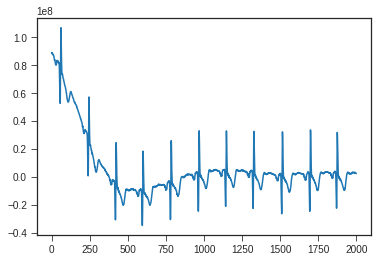

In [ ]:
plt.plot(ekg['ekg'][20000:22000])    # 깨끗한 데이터는 아님

In [ ]:
import datetime
now = datetime.datetime.now()
nowDate = now.strftime('%Y-%m-%d')
print(nowDate)      # 현재의 오늘 날짜
nowDatetime = now.strftime('%Y-%m-%d %H:%M:%S')
print(nowDatetime)  # 현재의 오늘 날짜와 시간

2022-07-27
2022-07-27 13:06:12


In [ ]:
def hrvInsert(device_type, dataset_id, edf_start_obj, ss_end_obj, window_size, hrv):
    if FLAG_MYSQL:
        conn = pymysql.connect(host='localhost', user='wysensor', password='wysensor1234', db='simdori', charset='utf8')
        cur = conn.cursor()
    sql_column = "device_mac, dataset_id, datetime, window_size"
    sql_value = f"'{device_type}', '{dataset_id}', '{ss_end_obj}', '{window_size}'"
    sql_update = ""
    for key in hrv:
        if key == "percentile_hr": # percentile_hr은 저장하지 않는다.
            continue
        sql_column += f", {key}"
        sql_value += f", '{hrv[key]}'"
        sql_update += f" {key}='{hrv[key]}',"

    sql = f"INSERT INTO mmwave_hrv ({sql_column}) VALUES ({sql_value}) ON DUPLICATE KEY UPDATE{sql_update[:-1]}"
#     print(f"after db/file, hrv_output:{hrv}")
    if FLAG_MYSQL:
        print(f"sql:{sql}")
        cur.execute(sql)
        conn.commit()   
        conn.close()


In [ ]:

# edf_f.close()
# import tracemalloc

# tracemalloc.start()
from scipy.signal import find_peaks, peak_prominences
from scipy import signal
import heartpy as hp # 피크 감지

import pyedflib
MAX_ALLOWED_CORRUPTION = 45
FLAG_MYSQL=False
FLAG_OUTLIER = False
FLAG_Z_OUTLIER = False
FLAG_RRI = False
hrv_step=5
FLAG_MATPLOT = False # plt.plot 가 memory 누수를 일으킴
FLAG_HR_PIC = False
for dataset_id, directory in enumerate(Patientlist):
    print(f"dataset_id:{dataset_id}, directory:{directory}===================================================================================")
    mac = os.path.split(directory)[1] # /home/wapeul/VitalSigns/202110901_EDF/input/kjh
    filelist = os.listdir(directory)  # 
    for file in filelist:
        if file.endswith(".edf"):
            edf_file = os.path.join(directory, file)
#         elif "Events" in file:
        elif file.endswith("a.txt"):
            event_file = os.path.join(directory, file)

# pyedflib read  
    edf_f = pyedflib.EdfReader(edf_file)
    list_signal = edf_f.getSignalLabels()
    ekg_index = list_signal.index('EKG')
    ekg = {}
    ekg['ekg'] = edf_f.readSignal(ekg_index)    
    ekg['sampling_rate'] = int(len(ekg['ekg'])/edf_f.getFileDuration())
    fs = ekg['sampling_rate']
    edf_start_obj = edf_f.getStartdatetime()
    edf_start_unix = time.mktime(edf_start_obj.timetuple()) #mktime.edf_start_obj
    print(f"edf_length:{len(ekg['ekg'])}[frame],edf_start_obj:{edf_start_obj}, edf_start_unix:{edf_start_unix}, duration:{edf_f.getFileDuration()/3600}[sec]")
    edf_f.close()    

    f = open(event_file, 'r')
    i = 0
    hrv_count=0
    
    while True:
        line = f.readline()
        if not line:
            break
        i += 1
        if i ==2:
            items = line.split(":")
            patient_id = items[1]
            patient_id = ''.join(char for char in patient_id if char.isalnum())
            print(f"patient_id:{patient_id}")
        elif i < 17: # if hrv file stop after 90, then put 90 for this.
             pass
        # elif i >= 21:# test 5
        #     break
        else:
            print(f"\r{i}    ", end="")
            items = line.split("\t")
            print(f'items : {items}')
            ss = items[0] # sleepstage
            print(f'ss : {ss}')
            print(f'item : {items[2]}')
            # ss_end_obj = datetime.datetime.strptime(items[2], '%Y-%m-%dT%H:%M:%S.000000')
            ss_end_obj = datetime.datetime.strptime(items[2], '%Y-%m-%dT%H:%M:%S.000000')
            print(f'ss_end_obj : {ss_end_obj}')
            # ss_end_obj = int(time.mktime(items[2].timetuple()))
            ss_end_unix = time.mktime(ss_end_obj.timetuple())
            ss_start_unix = ss_end_unix - hrv_step*60
            ss_start_obj = datetime.datetime.fromtimestamp(ss_start_unix) 
            end_index = int(ss_end_unix-edf_start_unix)*int(fs)
            start_index = end_index - hrv_step*60*int(fs)# 원래는 -1 frame 해줘야 하나 가독성을 위해 그냥 남김

            print(f"{i}line,  start_index:{start_index}, end_index: {end_index}, fs:{fs}")
            if start_index < 0 :
                print(f" start_index:{start_index} is smalller than 0, so we just pass this HRV {hrv_step} min segment")
                continue
            # detector algorithm
            detectors = Detectors(fs)
            al_offset = 3*fs
            x =ekg['ekg'][start_index-al_offset:end_index+al_offset]
            peaks = detectors.hamilton_detector(x)
            rpeaks = np.array(peaks)
            if FLAG_HR_PIC:
                plt.figure(figsize=(80,8))
                plt.plot(x)
                plt.plot(rpeaks, x[rpeaks], "x" , color ='red')
                plt.show() 
            rpeaks = rpeaks[np.where((rpeaks >= al_offset) & (rpeaks < len(x)-al_offset))]
            rpeaks = rpeaks -al_offset
            MAX_RRI = int(1500/(1000/fs))
            MIN_RRI = int(350/(1000/fs))
            # rpeaks = rpeaks *int(1000/fs)
            rri = np.diff(rpeaks) 

#             rri = int(rri)
#             print(f"\nrri:{rri}, len:{len(rri)}")
#             print(f"\nrpeaks:{rpeaks}, len:{len(rpeaks)}, max rpeaks:{rpeaks.max()}")
#             for d,dd in enumerate(rri):
#                 print(f"index:{d},{dd}, rri[d]:{dd}")
#                 print(f"(start,end):({rpeaks[d]},{rpeaks[d+1]})")
            
            arr = np.array([])
            mu = rri.mean()
            sigma=rri.std() 
            
            upper_bound = mu+2*sigma
            lower_bound = mu-2*sigma   
            # print(f"rri.mean:{mu}upper_bound:{upper_bound},lower_bound:{lower_bound}, MAX_RRI:{MAX_RRI}, MIN_RRI:{MIN_RRI} ")
            
#             for r in rpeaks:
#                 temp_r=abs(rpeaks[r]-rpeaks[r+1]-)
#                 rejected_rpeaks=rpeaks[r+1]
              
#             rri1= np.diff(rpeaks)
#             rri2= np.diff(rpeaks,2)-
#             if 
#             modified_peaks = rpeaks[]
            
#             if rri > upper_bound:
#                 rri_index = np.where(rri>upper_bound)
#                 print(f"rri_index:{rri_index}, rri[rri_index]:{rri[rri_index]}, rpeak[rri_index+1]:{rpeak[rri_index+1]}")
#             ddd = np.array([])

            wrong_rri_index = np.where((rri>MAX_RRI) | (rri< MIN_RRI) )[0] #|(rri > upper_bound) | (rri < lower_bound)
            if len(wrong_rri_index):
                # print(f"wrong_rri_index:{wrong_rri_index}, wrong rri:{rri[wrong_rri_index]} len of wrong_rri_index:{len(wrong_rri_index)}")
                wrong_end_peaks = rpeaks[wrong_rri_index[wrong_rri_index!=0]]
                # print(f"wrong_end_peaks:{wrong_end_peaks}")
                # print(f"rpeaks:\n{rpeaks}, rri:\n{rri}")
                
#             for d, dd in enumerate(wrong_rri_index) :
#                 print(f"index:{d}, rri[d]:{dd}")
#                 print(f"(start,end):({rpeaks[dd]},{rpeaks[dd+1]})")

#             import os
#             os.exit()
            out_of_range_rri = rri[(rri > MAX_RRI) | (rri <  MIN_RRI) ] #|(rri > upper_bound) | (rri < lower_bound)
            
            total_corrupted_rri = np.sum(out_of_range_rri)
            total_corrupted_rri_per = total_corrupted_rri/(hrv_step*12000)*100 # 1분 frame 개수: 12000frames = 60sec*200frames/sec
            print(f"len(wrong_end_peaks):{len(wrong_end_peaks)}, total_corrupted_rri:{total_corrupted_rri},total_corrupted_rri_per:{total_corrupted_rri_per}")
            modified_rri = rri[(rri<=MAX_RRI) & (rri>= MIN_RRI) & (rri <= upper_bound) & (rri >= lower_bound)]
            BPM = (len(modified_rri)+1)/5
            print(f" ========================= BPM:{BPM}")
#             import os
#             os.exit()
            print(f'before_rpeaks : {rpeaks}')
            if (len(rpeaks) == 0) :
                print(f'rpeaks : {rpeaks}')
                print(f"No RRI is detected \n")
                print(f"rpeaks can be null. So, we pass it to the next loop, num_rri:{len(modified_rri)}")
                if FLAG_HR_PIC:
                    plt.figure(figsize=(80,8))
                    plt.plot(x)
                    plt.plot(rpeaks, x[rpeaks], "x" , color ='red')
                    plt.show() 
                print("Pass this HRV==============================================================================")
                continue
          
            if MAX_ALLOWED_CORRUPTION < total_corrupted_rri_per or BPM < 20:
                print(f"This 30 seconds are too much corrupted:(%) {total_corrupted_rri_per}")
                print(f" BPM:{BPM}, rpeaks:\n{rpeaks}, \nrri:\n{rri}, \nmu:{mu}, total_corrupted_rri_per(%):{total_corrupted_rri_per},\out_of_range_rri[s]:\n{out_of_range_rri}")
                if FLAG_HR_PIC:
                    plt.figure(figsize=(80,8))
                    plt.plot(x)
                    plt.plot(rpeaks, x[rpeaks], "x" , color ='red')
                    plt.show() 
                
                print("Pass this HRV==============================================================================")
                continue

            elif (rri.max()>5000):
                if FLAG_HR_PIC:
                    plt.figure(figsize=(80,8))
                    plt.plot(x)
                    plt.plot(rpeaks, x[rpeaks], "x" , color ='red')
                    plt.show() 
                print(f" BPM:{BPM}, {rri.max()} long RRI is detected but we go to HRV calc \n")
                continue
            else:    
                print(f"Into HRV, Normal case: BPM:{BPM}")
#                 print(f"rpeaks:{rpeaks}")
#                 print(f"wrong_peaks:{wrong_end_peaks}")
                if FLAG_HR_PIC:
                    plt.figure(figsize=(200,8))
                    plt.plot(x)
                    plt.plot(rpeaks, x[rpeaks], markersize=5, label="Found peaks", color="red", marker="x", linestyle="None")
                    plt.plot(wrong_end_peaks, x[wrong_end_peaks], markersize=7, label="Wrong Found peaks", color="orange", marker="o", linestyle="None")
                    plt.show() 

            hrv_output = get_hrv(modified_rri*(1000/fs), fig_file_name=None)#(1000/fs) 로 ms 단위로 conversion
            
            if ss == "W":
                ss = 0
            elif ss == "N1":
                ss = 1
            elif ss == "N2":
                ss = 2
            elif ss == "N3":
                ss = 2
            elif ss == "R":
                ss = 3
            hrv_output['SS'] = ss
            hrv_output['nec'] = arrhythmia.NumberOfContainDataPoint(rri) # hrv 계산
            hrv_output['etc'] = 1 # all outliers are applied
            hrv_output['remark'] = hrv_count
            hrv_output['subject']= mac
            hrv_output['patient_id'] = patient_id
            hrv_output['ss_end_obj'] = ss_end_obj
#             print(f"\nhrv_output : {hrv_output}\n")
            hrvInsert(mac, patient_id, edf_start_obj ,ss_end_obj, hrv_step*60, hrv_output) # db에 추가.
            hrv_count=hrv_count+1
    print(f"{i}-----------------------------------------------------------------------------------------")
    f.close()

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
 55944 56150 56371 56592 56798 57003 57227 57457 57669 57874 58100 58324
 58530 58740 58969 59174 59369 59546 59726 59919]
Into HRV, Normal case: BPM:62.4
816    items : ['N2', 'Supine', '2020-04-28T03:26:38.000000', 'SLEEP-S2', '31', 'EEG-F3\n']
ss : N2
item : 2020-04-28T03:26:38.000000
ss_end_obj : 2020-04-28 03:26:38
816line,  start_index:4874400, end_index: 4934400, fs:200
len(wrong_end_peaks):4, total_corrupted_rri:0,total_corrupted_rri_per:0.0
 ========================= BPM:60.0
before_rpeaks : [  125   274   423   573   713   868  1015  1162  1308  1453  1595  1735
  1873  2008  2129  2274  2405  2528  2664  2792  2920  3047  3173  3299
  3425  3551  3678  3808  3942  4080  4221  4363  4505  4646  4789  4935
  5096  5282  5448  5627  5847  6088  6312  6514  6733  6970  7207  7422
  7627  7830  8037  8287  8503  8714  8948  9201  9443  9665  9909 10159
 10382 10599 10832 11056 11267 11492 11724 11933 12135 12355 12578 12779
 12986 13199 13390 1

In [ ]:
%cd ./

/content/drive/MyDrive/cs/mission_1/wysensor
